Paso 1: Importaciones y configuración

In [1]:
import os
import glob
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rasterio.plot import show
import fiona, time
import pyarrow

# Configuración de rutas relativas (asumiendo que el notebook está en /notebooks)
RAW_DIR = "../data/raw"
FIGURE_DIR = "../outputs/figures"
SHAPEFILE_DIR = "../outputs/figures/shapefile"
os.makedirs(SHAPEFILE_DIR, exist_ok=True)

print("✅ Librerías importadas y rutas configuradas.")

✅ Librerías importadas y rutas configuradas.


Exploración de rasters (viento, vegetación, altura)

In [2]:
# Diccionario con tus archivos raster clave
rasters = {
    "Viento (ERA5)": os.path.join(RAW_DIR, "era5_wind_valdivia.tif"),
    "Vegetación (Sentinel-2)": os.path.join(RAW_DIR, "sentinel2_valdivia.tif"),
    "Topología (SRTM)": os.path.join(RAW_DIR, "srtm_valdivia.tif") # Corregí strm a srtm
}

print("--- METADATA DE RASTERS ---")
for nombre, ruta in rasters.items():
    if os.path.exists(ruta):
        with rasterio.open(ruta) as src:
            print(f"📂 {nombre}:")
            print(f"   - Sistema de Coordenadas (CRS): {src.crs}")
            print(f"   - Tamaño: {src.width}x{src.height} píxeles")
            print(f"   - Bandas: {src.count}")
            print(f"   - Tipo de dato: {src.dtypes[0]}")
            print("-" * 30)
    else:
        print(f"❌ NO ENCONTRADO: {nombre} en {ruta}")

--- METADATA DE RASTERS ---
📂 Viento (ERA5):
   - Sistema de Coordenadas (CRS): EPSG:4326
   - Tamaño: 16x16 píxeles
   - Bandas: 2
   - Tipo de dato: float64
------------------------------
📂 Vegetación (Sentinel-2):
   - Sistema de Coordenadas (CRS): EPSG:32718
   - Tamaño: 1228x1467 píxeles
   - Bandas: 4
   - Tipo de dato: uint16
------------------------------
📂 Topología (SRTM):
   - Sistema de Coordenadas (CRS): EPSG:4326
   - Tamaño: 521x484 píxeles
   - Bandas: 1
   - Tipo de dato: int16
------------------------------



Diagnóstico de cobertura:
   Total píxeles      : 256
   Píxeles válidos    : 256
   Píxeles sin datos  : 0
   % sin datos        : 0.00%
   % cobertura útil   : 100.00%

Estadísticas para Viento (ERA5):

 Banda U
   min: 0.296
   max: 1.263
   mean: 0.636
   std: 0.271
   p5: 0.296
   p50: 0.502
   p95: 1.010


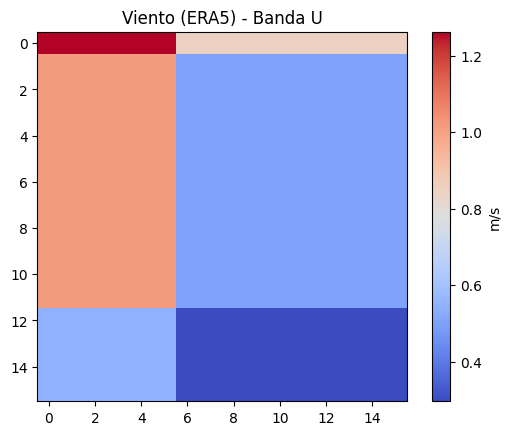


 Banda V
   min: 1.945
   max: 2.553
   mean: 2.090
   std: 0.186
   p5: 1.945
   p50: 1.961
   p95: 2.360


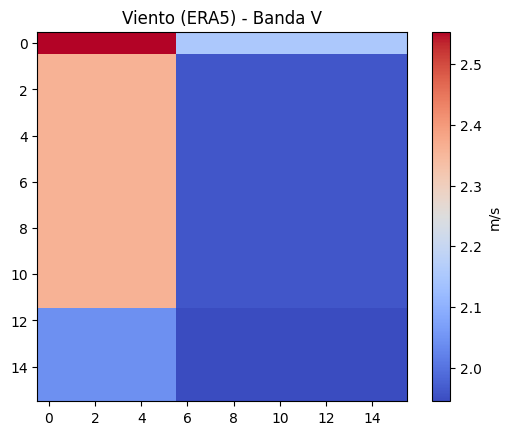


Magnitud del viento
   min: 1.967
   max: 2.848
   mean: 2.194
   std: 0.260
   p5: 1.967
   p50: 2.024
   p95: 2.567


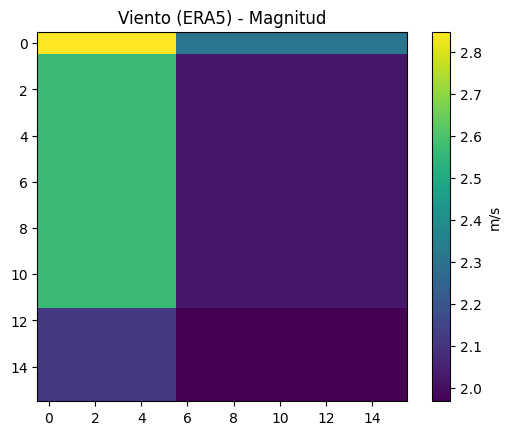


Dirección del viento


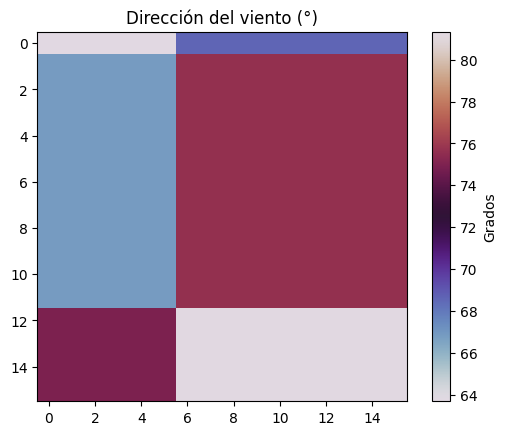


Diagnóstico de cobertura:
   Total píxeles      : 1,801,476
   Píxeles válidos    : 1,801,476
   Píxeles sin datos  : 0
   % sin datos        : 0.00%
   % cobertura útil   : 100.00%

Estadísticas para Vegetación (Sentinel-2):


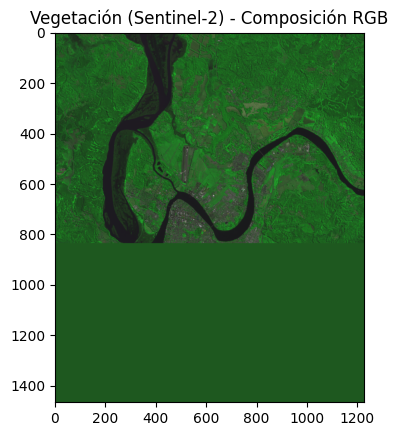


NDVI
   min: -0.504
   max: 0.424
   mean: -0.037
   std: 0.039
   p5: -0.128
   p50: -0.025
   p95: -0.005


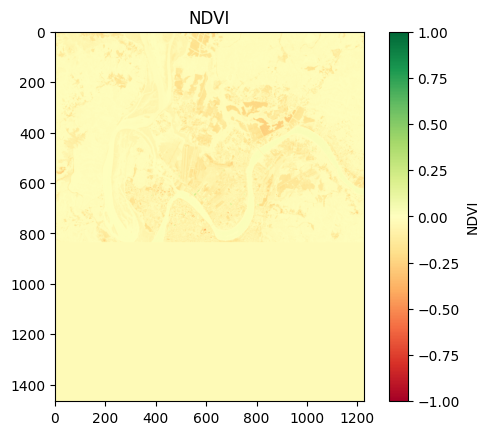

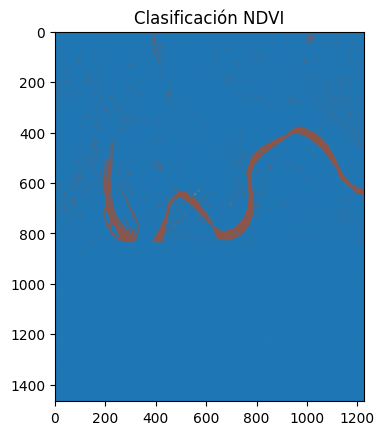


Diagnóstico de cobertura:
   Total píxeles      : 252,164
   Píxeles válidos    : 234,637
   Píxeles sin datos  : 17,527
   % sin datos        : 6.95%
   % cobertura útil   : 93.05%

Estadísticas para Topología (SRTM):

Elevación
   min: -21.00
   max: 343.00
   mean: 52.27
   std: 74.10
   p5: 0.00
   p50: 15.00
   p95: 229.00


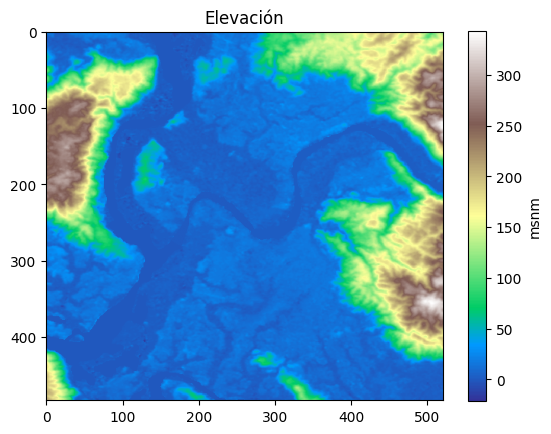


Pendiente


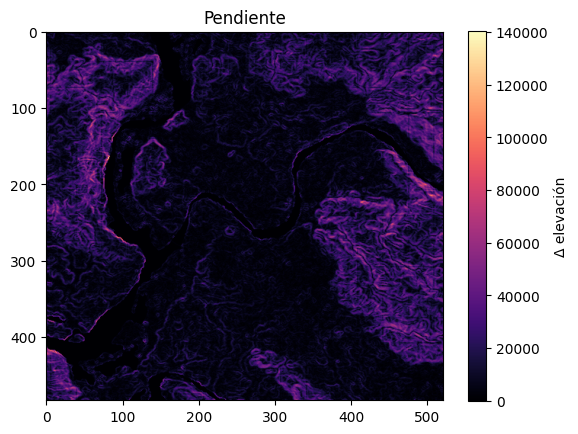

Figuras guardadas en: ../outputs/figures/raster


In [ ]:
RASTER_DIR = "../outputs/figures/raster"
os.makedirs(RASTER_DIR, exist_ok=True)

# Método para obtener estadística de los pixeles del raster
def diagnostico_cobertura(data, nodata_value=0):
    """
    Estima porcentaje de píxeles inválidos (sin datos reales).
    Considera nodata cuando todas las bandas son nodata_value.
    """
    # Para raster multibanda: nodata si TODAS las bandas son nodata
    if data.ndim == 3:
        mask_nodata = np.all(data == nodata_value, axis=0)
    else:
        mask_nodata = data == nodata_value

    total_pix = mask_nodata.size
    nodata_pix = np.sum(mask_nodata)
    valid_pix = total_pix - nodata_pix
    porcentaje = (nodata_pix / total_pix) * 100

    return {
        "total_pixeles": total_pix,
        "pixeles_validos": valid_pix,
        "pixeles_nodata": nodata_pix,
        "porcentaje_nodata": porcentaje,
        "porcentaje_cobertura": 100 - porcentaje
    }

# Método para obtener estadísticas del raster
def estadisticas_basicas(arr):
    """Calcula estadísticas clásicas ignorando NaN."""
    arr = arr[np.isfinite(arr)]
    return {
        "min": np.min(arr),
        "max": np.max(arr),
        "mean": np.mean(arr),
        "std": np.std(arr),
        "p5": np.percentile(arr, 5),
        "p50": np.percentile(arr, 50),
        "p95": np.percentile(arr, 95)
    }

# Método para imprimir un histograma de los raster
def plot_histograma(arr, titulo, fname):
    """Grafica histograma de una banda."""
    arr = arr[np.isfinite(arr)]
    plt.figure()
    plt.hist(arr, bins=50)
    plt.title(titulo)
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.savefig(os.path.join(RASTER_DIR, fname), dpi=300, bbox_inches="tight")
    plt.close()

os.makedirs(RASTER_DIR, exist_ok=True)

for nombre, ruta in rasters.items():
    if os.path.exists(ruta):
        with rasterio.open(ruta) as src:
            data = src.read()

            # Evaluar los pixeles de data
            diag = diagnostico_cobertura(data)

            print("\nDiagnóstico de cobertura:")
            print(f"   Total píxeles      : {diag['total_pixeles']:,}")
            print(f"   Píxeles válidos    : {diag['pixeles_validos']:,}")
            print(f"   Píxeles sin datos  : {diag['pixeles_nodata']:,}")
            print(f"   % sin datos        : {diag['porcentaje_nodata']:.2f}%")
            print(f"   % cobertura útil   : {diag['porcentaje_cobertura']:.2f}%")

            print(f"\nEstadísticas para {nombre}:")
            
            # ERA5 VIENTO
            if "Viento" in nombre:
                u, v = data

                for i, band in enumerate([u, v]):
                    eje = "U" if i == 0 else "V"

                    print(f"\n Banda {eje}")
                    stats = estadisticas_basicas(band)
                    for k, val in stats.items():
                        print(f"   {k}: {val:.3f}")

                    # Mapa banda
                    plt.imshow(band, cmap="coolwarm")
                    plt.title(f"{nombre} - Banda {eje}")
                    plt.colorbar(label="m/s")
                    fname = f"{nombre.replace(' ', '_').lower()}_{eje}.png"
                    plt.savefig(os.path.join(RASTER_DIR, fname), dpi=300, bbox_inches="tight")
                    plt.show()

                    # Histograma
                    plot_histograma(
                        band,
                        f"Histograma viento banda {eje}",
                        f"hist_viento_{eje}.png",
                    )

                # Magnitud
                mag = np.sqrt(u**2 + v**2)

                print("\nMagnitud del viento")
                stats = estadisticas_basicas(mag)
                for k, val in stats.items():
                    print(f"   {k}: {val:.3f}")

                plt.imshow(mag, cmap="viridis")
                plt.title(f"{nombre} - Magnitud")
                plt.colorbar(label="m/s")
                plt.savefig(os.path.join(RASTER_DIR, "viento_magnitud.png"), dpi=300)
                plt.show()

                plot_histograma(
                    mag,
                    "Histograma magnitud del viento",
                    "hist_viento_magnitud.png",
                )

                # Dirección 
                direc = np.arctan2(v, u) * 180 / np.pi
                direc = (direc + 360) % 360

                print("\nDirección del viento")
                plt.imshow(direc, cmap="twilight")
                plt.title("Dirección del viento (°)")
                plt.colorbar(label="Grados")
                plt.savefig(os.path.join(RASTER_DIR, "viento_direccion.png"), dpi=300)
                plt.show()

            # SENTINEL-2 VEGETACIÓN
            elif "Vegetación" in nombre:

                # RGB
                rgb = np.dstack([data[0], data[1], data[2]])

                plt.imshow(rgb / np.max(rgb))
                plt.title(f"{nombre} - Composición RGB")
                plt.savefig(os.path.join(RASTER_DIR, "sentinel_rgb.png"), dpi=300)
                plt.show()

                # NDVI 
                red = data[0].astype(float)
                nir = data[3].astype(float)

                ndvi = (nir - red) / (nir + red + 1e-6)

                print("\nNDVI")
                stats = estadisticas_basicas(ndvi)
                for k, val in stats.items():
                    print(f"   {k}: {val:.3f}")

                plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
                plt.title("NDVI")
                plt.colorbar(label="NDVI")
                plt.savefig(os.path.join(RASTER_DIR, "ndvi.png"), dpi=300)
                plt.show()

                plot_histograma(ndvi, "Histograma NDVI", "hist_ndvi.png")

                # ----- Clasificación NDVI -----
                clases = np.zeros_like(ndvi)
                clases[ndvi < 0] = 0
                clases[(ndvi >= 0) & (ndvi < 0.2)] = 1
                clases[(ndvi >= 0.2) & (ndvi < 0.5)] = 2
                clases[ndvi >= 0.5] = 3

                plt.imshow(clases, cmap="tab10")
                plt.title("Clasificación NDVI")
                plt.savefig(os.path.join(RASTER_DIR, "clases_ndvi.png"), dpi=300)
                plt.show()

            # SRTM TOPOGRAFÍA
            elif "Topología" in nombre:

                elev = data[0]

                print("\nElevación")
                stats = estadisticas_basicas(elev)
                for k, val in stats.items():
                    print(f"   {k}: {val:.2f}")

                plt.imshow(elev, cmap="terrain")
                plt.title("Elevación")
                plt.colorbar(label="msnm")
                plt.savefig(os.path.join(RASTER_DIR, "elevacion.png"), dpi=300)
                plt.show()

                plot_histograma(
                    elev,
                    "Histograma elevación",
                    "hist_elevacion.png"
                )

                # Pendiente
                dy, dx = np.gradient(elev, src.res[1], src.res[0])
                slope = np.sqrt(dx**2 + dy**2)

                print("\nPendiente")
                plt.imshow(slope, cmap="magma")
                plt.title("Pendiente")
                plt.colorbar(label="Δ elevación")
                plt.savefig(os.path.join(RASTER_DIR, "pendiente.png"), dpi=300)
                plt.show()
    
print(f"Figuras guardadas en: {RASTER_DIR}")

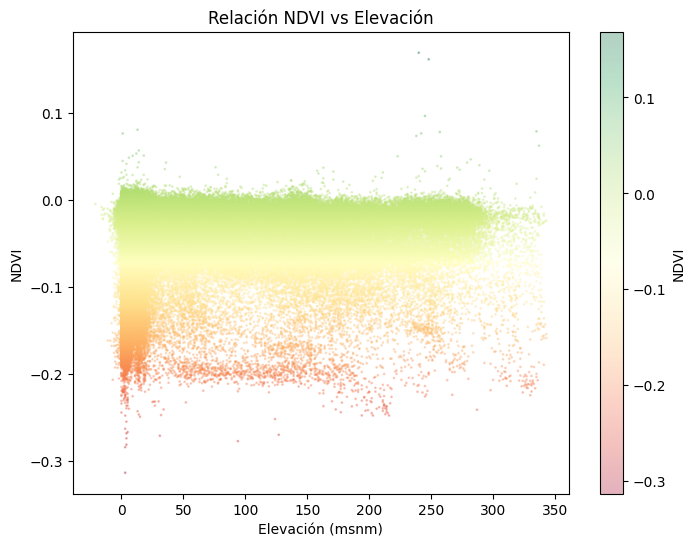

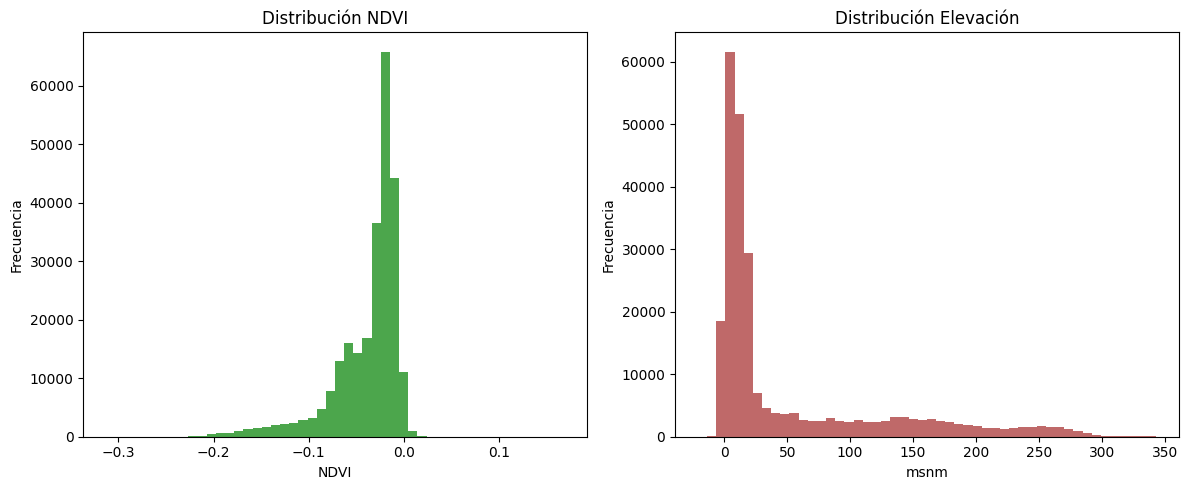

In [ ]:
# --- NDVI (Sentinel-2) ---
with rasterio.open(rasters["Vegetación (Sentinel-2)"]) as src:
    data = src.read()
    nir = data[3].astype(float)
    red = data[0].astype(float)
    ndvi = (nir - red) / (nir + red + 1e-6)

# --- Elevación (SRTM) ---
with rasterio.open(rasters["Topología (SRTM)"]) as src:
    elev = src.read(1).astype(float)

# --- Ajuste de dimensiones ---
min_shape = (min(ndvi.shape[0], elev.shape[0]), min(ndvi.shape[1], elev.shape[1]))
ndvi_crop = ndvi[:min_shape[0], :min_shape[1]]
elev_crop = elev[:min_shape[0], :min_shape[1]]

# Crear carpeta RASTER_DIR si no existe
os.makedirs(RASTER_DIR, exist_ok=True)

# --- Scatter plot NDVI vs Elevación ---
plt.figure(figsize=(8,6))
plt.scatter(elev_crop.flatten(), ndvi_crop.flatten(), s=1, alpha=0.3,
            c=ndvi_crop.flatten(), cmap="RdYlGn")
plt.xlabel("Elevación (msnm)")
plt.ylabel("NDVI")
plt.title("Relación NDVI vs Elevación")
plt.colorbar(label="NDVI")

# Guardar figura
scatter_path = os.path.join(RASTER_DIR, "ndvi_vs_elevacion_scatter.png")
plt.savefig(scatter_path, dpi=300, bbox_inches="tight")
plt.show()

# --- Histogramas comparativos ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(ndvi_crop.flatten(), bins=50, color="green", alpha=0.7)
plt.title("Distribución NDVI")
plt.xlabel("NDVI")
plt.ylabel("Frecuencia")

plt.subplot(1,2,2)
plt.hist(elev_crop.flatten(), bins=50, color="brown", alpha=0.7)
plt.title("Distribución Elevación")
plt.xlabel("msnm")
plt.ylabel("Frecuencia")

plt.tight_layout()

# Guardar figura
hist_path = os.path.join(RASTER_DIR, "ndvi_elevacion_histogramas.png")
plt.savefig(hist_path, dpi=300, bbox_inches="tight")
plt.show()


Exploración de CONAF (Amenaza y Riesgo)

--- EXPLORACIÓN VECTORIAL CONAF ---
✅ Amenaza cargada. Filas: 941695
Columnas disponibles: ['Id', 'gridcode', 'geometry']


,Id,gridcode,geometry
0,1,3,"POLYGON ((166489.924 5644161.752, 166499.924 5..."
1,2,4,"POLYGON ((166559.924 5644141.752, 166489.924 5..."
2,3,3,"POLYGON ((166559.924 5644141.752, 166559.924 5..."


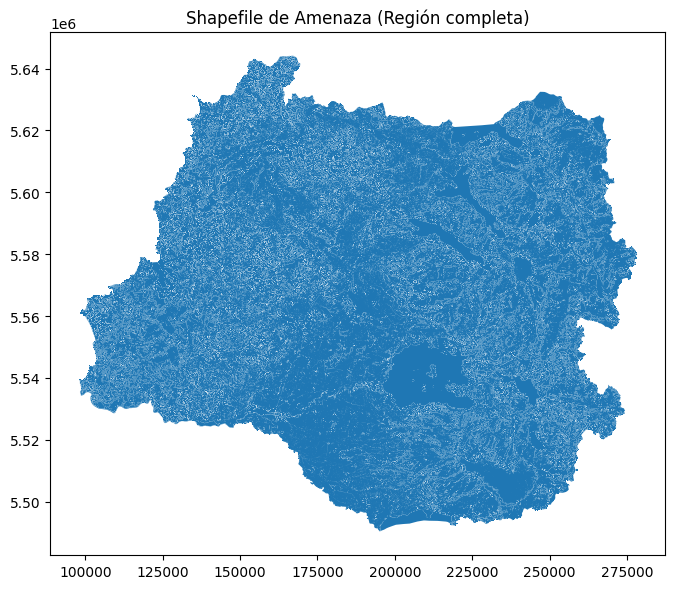

Distribución de niveles de amenaza (Polígonos):
gridcode
0     29754
1    397632
2    218591
3    231614
4     64104
Name: count, dtype: int64


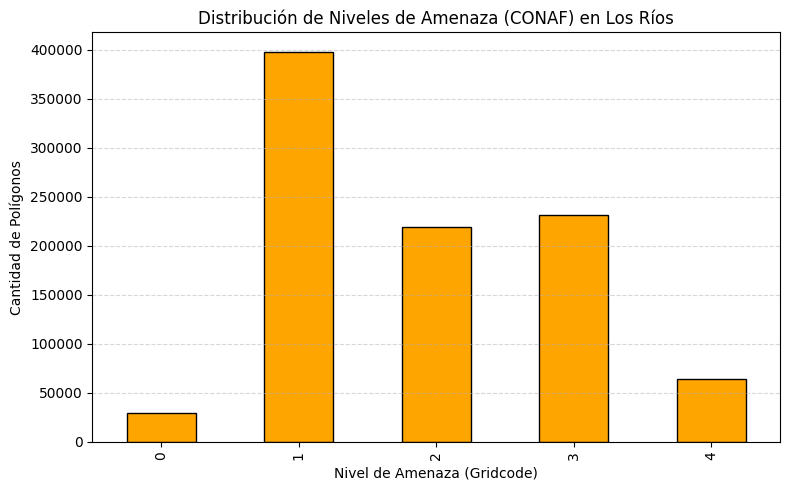

💡 Interpretación: Este gráfico nos dice si la región es mayoritariamente segura o peligrosa.


In [13]:
SHAPEFILE_DIR = "../outputs/figures/shapefile"
os.makedirs(SHAPEFILE_DIR, exist_ok=True)

# Rutas a los shapefiles de CONAF
path_amenaza = os.path.join(RAW_DIR, "conaf_amenaza/shapefiles/14_amenaza_shape.shp")
path_riesgo = os.path.join(RAW_DIR, "conaf_riesgo/shapefiles/14_riesgo_shape.shp")

print("--- EXPLORACIÓN VECTORIAL CONAF ---")

if os.path.exists(path_amenaza):
    gdf_amenaza = gpd.read_file(path_amenaza, use_arrow=True)
    print(f"✅ Amenaza cargada. Filas: {len(gdf_amenaza)}")
    print("Columnas disponibles:", gdf_amenaza.columns.tolist())
    display(gdf_amenaza.head(3)) 
    
    # Visualización rápida del mapa
    ax = gdf_amenaza.plot(figsize=(8, 6))
    plt.title("Shapefile de Amenaza (Región completa)")
    plt.tight_layout()
    plt.savefig(os.path.join(SHAPEFILE_DIR, "amenaza_mapa.png"), dpi=300)
    plt.show()
else:
    print(f"❌ No se encontró el archivo de Amenaza: {path_amenaza}")


# --- ESTADÍSTICAS DE AMENAZA (CONAF) ---
if 'gridcode' in gdf_amenaza.columns:
    conteo_amenaza = gdf_amenaza['gridcode'].value_counts().sort_index()
    
    print("Distribución de niveles de amenaza (Polígonos):")
    print(conteo_amenaza)

    # Gráfico de Barras
    plt.figure(figsize=(8, 5))
    conteo_amenaza.plot(kind='bar', color='orange', edgecolor='black')
    plt.title("Distribución de Niveles de Amenaza (CONAF) en Los Ríos")
    plt.xlabel("Nivel de Amenaza (Gridcode)")
    plt.ylabel("Cantidad de Polígonos")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(SHAPEFILE_DIR, "amenaza_distribucion.png"), dpi=300)
    plt.show()
    
    print("💡 Interpretación: Este gráfico nos dice si la región es mayoritariamente segura o peligrosa.")

In [3]:
import os
from pathlib import Path
import geopandas as gpd

# Directorios
RAW_DIR = "../data/raw"
COMUNA_PROC_DIR = Path("../data/raw/comuna")
AMENAZAS_PROC_DIR = Path("../data/processed/amenazas")
AMENAZAS_PROC_DIR.mkdir(parents=True, exist_ok=True)

# Shapefile comuna Valdivia (ya creado antes)
comuna_valdivia_path = COMUNA_PROC_DIR / "comuna_valdivia.shp"

# Shapefile de amenaza CONAF (región, pero lo usaremos solo para recortar)
path_amenaza = os.path.join(
    RAW_DIR, "conaf_amenaza", "shapefiles", "14_amenaza_shape.shp"
)

print("=== CARGANDO COMUNA VALDIVIA ===")
gdf_comuna = gpd.read_file(comuna_valdivia_path)
print("CRS comuna:", gdf_comuna.crs)

print("\n=== CARGANDO AMENAZA CONAF (REGIÓN) ===")
gdf_amenaza = gpd.read_file(path_amenaza, use_arrow=True)
print("Filas amenaza (región):", len(gdf_amenaza))
print("CRS amenaza:", gdf_amenaza.crs)

# --- ALINEAR CRS ---

if gdf_amenaza.crs is None:
    raise ValueError(
        "⚠ La capa de amenaza no tiene CRS definido (crs=None). "
        "Asigna el CRS correcto con .set_crs(...) antes del clip."
    )

if gdf_amenaza.crs != gdf_comuna.crs:
    print("\n⚠ CRS distintos → reproyectando amenaza al CRS de la comuna (EPSG:5360)...")
    gdf_amenaza = gdf_amenaza.to_crs(gdf_comuna.crs)
    print("Nuevo CRS amenaza:", gdf_amenaza.crs)
else:
    print("\n✅ CRS ya coinciden.")

# Nos quedamos solo con la geometría de la comuna
gdf_comuna_geom = gdf_comuna[["geometry"]]

# --- CLIP SOLO VALDIVIA ---

print("\n=== CLIP DE AMENAZA POR COMUNA VALDIVIA ===")
gdf_amenaza_valdivia = gpd.clip(gdf_amenaza, gdf_comuna_geom)

print("Filas de amenaza dentro de Valdivia:", len(gdf_amenaza_valdivia))

# Guardar shapefile recortado (por si lo quieres usar después)
amenaza_valdivia_path = AMENAZAS_PROC_DIR / "amenaza_valdivia.shp"
gdf_amenaza_valdivia.to_file(amenaza_valdivia_path, driver="ESRI Shapefile")
print(f"✅ Shapefile de amenaza para Valdivia guardado en: {amenaza_valdivia_path}")

# Mostrar una vista rápida en tabla
display(gdf_amenaza_valdivia.head())

=== CARGANDO COMUNA VALDIVIA ===
CRS comuna: EPSG:5360

=== CARGANDO AMENAZA CONAF (REGIÓN) ===
Filas amenaza (región): 941695
CRS amenaza: EPSG:32719

⚠ CRS distintos → reproyectando amenaza al CRS de la comuna (EPSG:5360)...
Nuevo CRS amenaza: EPSG:5360

=== CLIP DE AMENAZA POR COMUNA VALDIVIA ===
Filas de amenaza dentro de Valdivia: 99516
✅ Shapefile de amenaza para Valdivia guardado en: ..\data\processed\amenazas\amenaza_valdivia.shp


,Id,gridcode,geometry
941692,941693,2,"MULTIPOLYGON (((-73.24841 -39.90579, -73.24829..."
495976,495977,2,"POLYGON ((-72.92223 -39.93784, -72.92222 -39.9..."
495446,495447,2,"POLYGON ((-72.92208 -39.9373, -72.92207 -39.93..."
494324,494325,2,"POLYGON ((-72.92259 -39.93593, -72.92259 -39.9..."
494325,494326,2,"POLYGON ((-72.92188 -39.93587, -72.92212 -39.9..."


=== GRÁFICOS DE AMENAZA SOLO PARA VALDIVIA ===


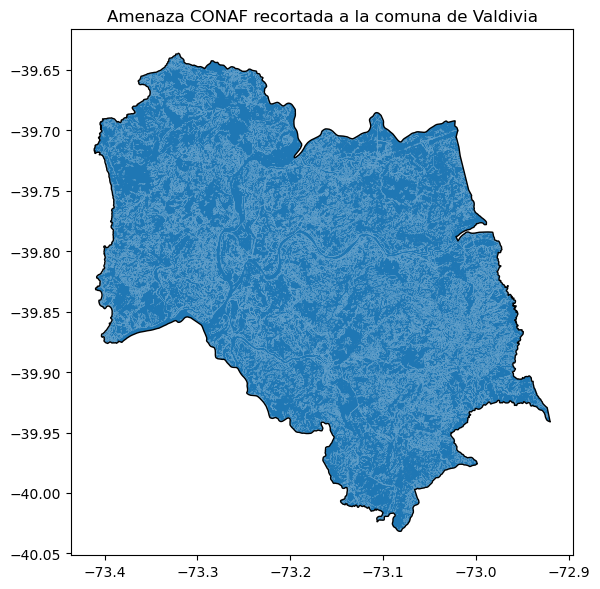

Distribución de niveles de amenaza (polígonos) en Valdivia:
gridcode
0     3126
1    26099
2    18483
3    36834
4    14974
Name: count, dtype: int64


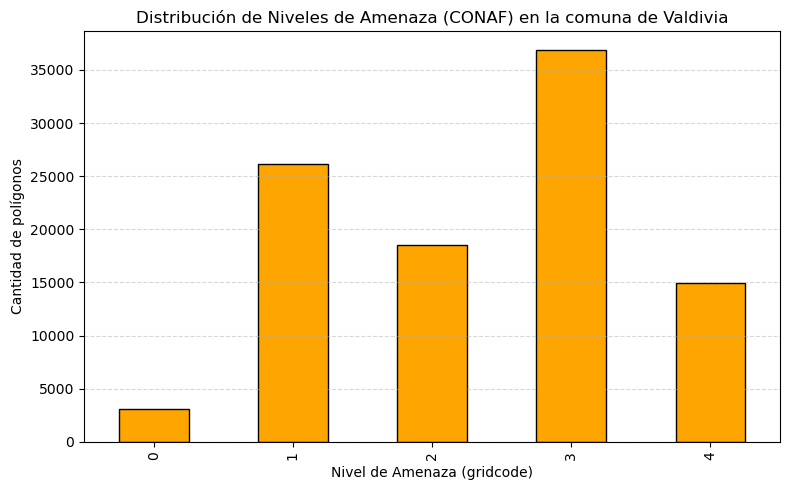

💡 Interpretación: este gráfico ya refleja solo la realidad de la comuna de Valdivia, no de toda la región.


In [4]:
import matplotlib.pyplot as plt
import os

# Carpeta de figuras
SHAPEFILE_DIR = "../outputs/figures/shapefile"
VALDIVIA_FIG_DIR = os.path.join(SHAPEFILE_DIR, "valdivia")
os.makedirs(VALDIVIA_FIG_DIR, exist_ok=True)

print("=== GRÁFICOS DE AMENAZA SOLO PARA VALDIVIA ===")

# --- MAPA SOLO VALDIVIA ---
ax = gdf_amenaza_valdivia.plot(figsize=(8, 6))
gdf_comuna.boundary.plot(ax=ax, linewidth=1, edgecolor="black")
plt.title("Amenaza CONAF recortada a la comuna de Valdivia")
plt.tight_layout()
plt.savefig(os.path.join(VALDIVIA_FIG_DIR, "amenaza_valdivia_mapa.png"), dpi=300)
plt.show()

# --- ESTADÍSTICAS Y GRÁFICO DE BARRAS SOLO VALDIVIA ---
if "gridcode" in gdf_amenaza_valdivia.columns:
    conteo_valdivia = gdf_amenaza_valdivia["gridcode"].value_counts().sort_index()
    
    print("Distribución de niveles de amenaza (polígonos) en Valdivia:")
    print(conteo_valdivia)

    plt.figure(figsize=(8, 5))
    conteo_valdivia.plot(kind="bar", color="orange", edgecolor="black")
    plt.title("Distribución de Niveles de Amenaza (CONAF) en la comuna de Valdivia")
    plt.xlabel("Nivel de Amenaza (gridcode)")
    plt.ylabel("Cantidad de polígonos")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(VALDIVIA_FIG_DIR, "amenaza_valdivia_distribucion.png"), dpi=300)
    plt.show()

    print("💡 Interpretación: este gráfico ya refleja solo la realidad de la comuna de Valdivia, no de toda la región.")
else:
    print("⚠ La capa de amenaza no tiene columna 'gridcode', no se puede hacer el gráfico de barras.")

Exploración Histórica (El "Loop" Inteligente): Recorre todas las carpetas de años, cuenta los incendios y hace el gráfico de tendencia.

--- ANÁLISIS TEMPORAL DE INCENDIOS (PANGAEA) ---


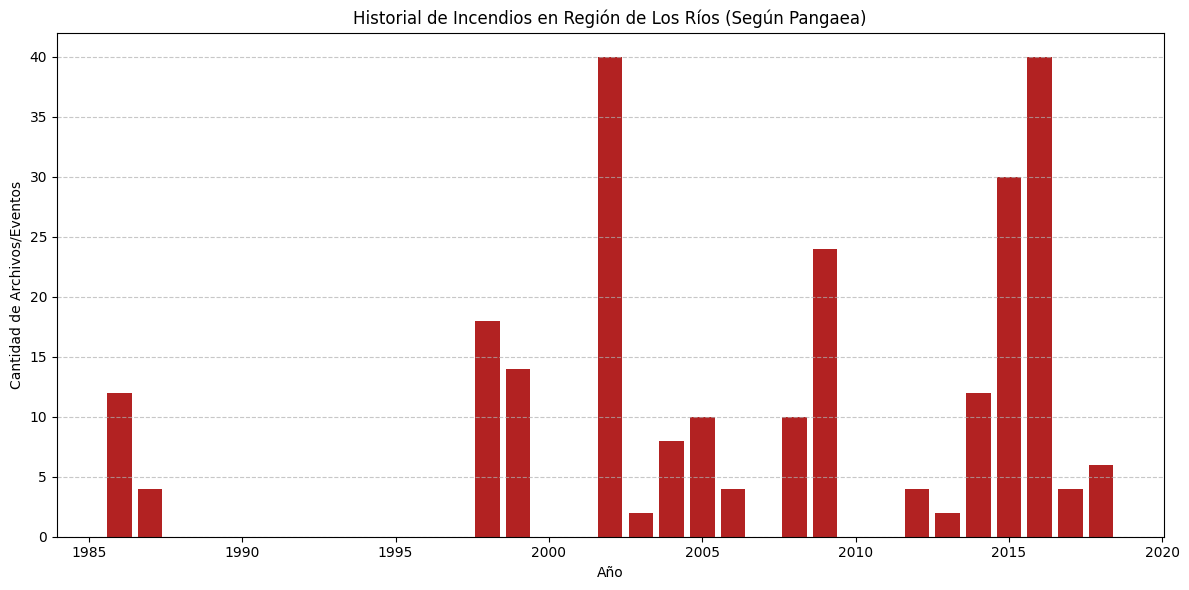

💡 Hallazgo: Este gráfico permite identificar los años más críticos antes de la simulación.


In [ ]:
SHAPEFILE_DIR = "../outputs/figures/shapefile"
os.makedirs(SHAPEFILE_DIR, exist_ok=True)

print("--- ANÁLISIS TEMPORAL DE INCENDIOS (PANGAEA) ---")

# Ruta base de Pangaea
base_pangaea = os.path.join(RAW_DIR, "incendios_pangaea/Fire_CL-LR_LosRios")

# Lista para guardar los datos del resumen
stats_incendios = []

# Buscar carpetas que tengan años (ej: ..._2017)
carpetas_anos = sorted(glob.glob(os.path.join(base_pangaea, "*_*")))

for carpeta in carpetas_anos:
    try:
        ano = int(carpeta.split("_")[-1])  # extraer año
        archivos_shp = glob.glob(os.path.join(carpeta, "*.shp"))
        cantidad = len(archivos_shp)
        stats_incendios.append({"Año": ano, "Incendios_Registrados": cantidad})
    except ValueError:
        continue  # saltar carpetas que no terminen en número

# Crear DataFrame para graficar
df_historia = pd.DataFrame(stats_incendios)

if not df_historia.empty:
    # Gráfico de barras: Serie Temporal
    plt.figure(figsize=(12, 6))
    plt.bar(df_historia["Año"], df_historia["Incendios_Registrados"], color='firebrick')
    plt.title("Historial de Incendios en Región de Los Ríos (Según Pangaea)")
    plt.xlabel("Año")
    plt.ylabel("Cantidad de Archivos/Eventos")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Guardar figura en SHAPEFILE_DIR
    plt.savefig(os.path.join(SHAPEFILE_DIR, "incendios_historial.png"), dpi=300)
    plt.show()
    
    print("💡 Hallazgo: Este gráfico permite identificar los años más críticos antes de la simulación.")
else:
    print("⚠️ No se encontraron carpetas de años válidas.")

In [ ]:
def load_with_progress(path, color="blue", title="Shapefile", output_name="output.png"):
    """Carga shapefile mostrando progreso y guarda visualización"""
    start_time = time.time()
    with fiona.open(path) as src:
        total = len(src)
        print(f"📂 Archivo: {path}")
        print(f"Total de features: {total}")
        for i, feature in enumerate(src, 1):
            if i % max(1, total // 10) == 0:
                elapsed = time.time() - start_time
                percent = (i / total) * 100
                print(f"   Progreso: {percent:.0f}% ({i}/{total}) en {elapsed:.2f} s")

    gdf = gpd.read_file(path)
    load_time = time.time() - start_time
    print(f"✅ Cargado en {load_time:.2f} segundos. Filas: {len(gdf)}")

    # Visualización
    ax = gdf.plot(figsize=(6,6), color=color, edgecolor="black")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(SHAPEFILE_DIR, output_name), dpi=300)
    plt.close()  # importante para no saturar memoria con muchas figuras

    return gdf


# --- CONAF: Amenaza y Riesgo ---
tasks = []
path_amenaza = os.path.join(RAW_DIR, "conaf_amenaza/shapefiles/14_amenaza_shape.shp")
if os.path.exists(path_amenaza):
    tasks.append(("CONAF - Amenaza", path_amenaza, "orange", "conaf_amenaza_vistazo.png"))

path_riesgo = os.path.join(RAW_DIR, "conaf_riesgo/shapefiles/14_riesgo_shape.shp")
if os.path.exists(path_riesgo):
    tasks.append(("CONAF - Riesgo", path_riesgo, "red", "conaf_riesgo_vistazo.png"))


# --- PANGAEA: Incendios ---
base_pangaea = os.path.join(RAW_DIR, "incendios_pangaea/Fire_CL-LR_LosRios")
carpetas_anos = sorted(glob.glob(os.path.join(base_pangaea, "*_*")))

for carpeta in carpetas_anos[:2]:  # ajusta el rango según lo que quieras procesar
    try:
        ano = int(carpeta.split("_")[-1])
        archivos_shp = glob.glob(os.path.join(carpeta, "*.shp"))
        if archivos_shp:
            tasks.append((f"PANGAEA - Incendio {ano}", archivos_shp[0], "firebrick", f"pangaea_incendio_{ano}_vistazo.png"))
    except ValueError:
        continue


# --- Paralelización ---
results = []
with ThreadPoolExecutor(max_workers=4) as executor:  # ajusta max_workers según tu CPU
    futures = {
        executor.submit(load_with_progress, path, color, title, output_name): title
        for title, path, color, output_name in tasks
    }
    for future in as_completed(futures):
        try:
            gdf_result = future.result()
            results.append(gdf_result)
            print(f"✅ Finalizado: {futures[future]} ({gdf_result.shape})")
        except Exception as e:
            print(f"❌ Error en {futures[future]}: {e}")


📂 Archivo: ../data/raw\conaf_amenaza/shapefiles/14_amenaza_shape.shp
Total de features: 941695
📂 Archivo: ../data/raw\conaf_riesgo/shapefiles/14_riesgo_shape.shp
Total de features: 984468
📂 Archivo: ../data/raw\incendios_pangaea/Fire_CL-LR_LosRios\FireScar_CL-LR_LosRios_1986\FireScar_CL-LR_ID10017_u400_19860108.shp
Total de features: 3
   Progreso: 33% (1/3) en 0.22 s
   Progreso: 67% (2/3) en 0.22 s
   Progreso: 100% (3/3) en 0.22 s
📂 Archivo: ../data/raw\incendios_pangaea/Fire_CL-LR_LosRios\FireScar_CL-LR_LosRios_1987\FireScar_CL-LR_ID13859_u350_19870318.shp
Total de features: 8
   Progreso: 12% (1/8) en 0.25 s
   Progreso: 25% (2/8) en 0.25 s
   Progreso: 38% (3/8) en 0.25 s
   Progreso: 50% (4/8) en 0.25 s
   Progreso: 62% (5/8) en 0.25 s
   Progreso: 75% (6/8) en 0.25 s
   Progreso: 88% (7/8) en 0.25 s
   Progreso: 100% (8/8) en 0.25 s
✅ Cargado en 4.61 segundos. Filas: 3✅ Cargado en 4.68 segundos. Filas: 8

   Progreso: 10% (94169/941695) en 5.25 s
   Progreso: 10% (98446/984468)

In [1]:
import geopandas as gpd
import os
import rasterio
from rasterio.mask import mask

# Definir las rutas
RAW_DIR = "../data/raw"
COMUNA_VALDIVIA_SHP = os.path.join(RAW_DIR, "comuna", "comuna_valdivia.shp")
CONAF_RIESGO_DIR = os.path.join(RAW_DIR, "conaf_riesgo", "raster")

# Función para cargar el shapefile de la comuna
def load_comuna(shp_path):
    if not os.path.exists(shp_path):
        raise FileNotFoundError(f"No existe: {shp_path}")
    gdf = gpd.read_file(shp_path)
    if gdf.empty:
        raise ValueError("El shapefile de comuna está vacío.")
    return gdf

# Función para encontrar el primer .tif en una carpeta
def find_first_tif(folder):
    if not os.path.isdir(folder):
        return None
    tifs = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(".tif")]
    return sorted(tifs)[0] if tifs else None

# Cargar el shapefile de la comuna de Valdivia
comuna = load_comuna(COMUNA_VALDIVIA_SHP)

# Buscar el primer raster CONAF (riesgo)
conaf_riesgo_tif = find_first_tif(CONAF_RIESGO_DIR)
print("Raster CONAF cargado:", conaf_riesgo_tif)

# Función para hacer el clip del raster con el shapefile de la comuna
def clip_raster_to_polygon(raster_path, polygon_gdf):
    with rasterio.open(raster_path) as src:
        poly = polygon_gdf.to_crs(src.crs)
        geoms = [geom for geom in poly.geometry if geom is not None]
        out_image, out_transform = mask(src, geoms, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "crs": src.crs,
            "nodata": src.nodata
        })
    return out_image, out_meta

# Realizar el clip del raster CONAF a la comuna de Valdivia
img, meta = clip_raster_to_polygon(conaf_riesgo_tif, comuna)

Raster CONAF cargado: ../data/raw\conaf_riesgo\raster\14_riesgo.tif


In [2]:
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Función para reproyectar el raster a EPSG:4326
def reproject_array_to_4326(arr2d, meta, resampling=Resampling.nearest):
    src_crs = meta["crs"]
    src_transform = meta["transform"]
    src_h, src_w = arr2d.shape
    left, bottom, right, top = rasterio.transform.array_bounds(src_h, src_w, src_transform)
    
    dst_crs = "EPSG:4326"
    dst_transform, dst_w, dst_h = calculate_default_transform(
        src_crs, dst_crs, src_w, src_h, left, bottom, right, top
    )
    
    dst = np.full((dst_h, dst_w), np.nan, dtype="float32")
    reproject(
        source=arr2d.astype("float32"),
        destination=dst,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        src_nodata=meta.get("nodata"),
        dst_nodata=np.nan,
        resampling=resampling
    )
    
    meta_4326 = meta.copy()
    meta_4326.update({
        "crs": rasterio.crs.CRS.from_string(dst_crs),
        "transform": dst_transform,
        "width": dst_w,
        "height": dst_h,
        "nodata": np.nan
    })
    
    return dst, meta_4326

# Reproyectamos el raster a EPSG:4326
data_4326, meta_4326 = reproject_array_to_4326(img[0], meta)

In [3]:
def downsample_with_meta(arr2d, meta_4326, factor=3):
    arr_ds = arr2d[::factor, ::factor]
    t = meta_4326["transform"]
    meta_ds = meta_4326.copy()
    meta_ds["transform"] = rasterio.Affine(
        t.a * factor, t.b, t.c,
        t.d, t.e * factor, t.f
    )
    meta_ds["width"] = arr_ds.shape[1]
    meta_ds["height"] = arr_ds.shape[0]
    return arr_ds, meta_ds

# Downsample para visualización
data_ds, meta_ds = downsample_with_meta(data_4326, meta_4326, factor=3)

In [4]:
from rasterio.transform import array_bounds

left, bottom, right, top = array_bounds(
    meta_ds["height"], meta_ds["width"], meta_ds["transform"]
)

# bounds en formato folium: [[lat_min, lon_min], [lat_max, lon_max]]
bounds = [[bottom, left], [top, right]]

bounds

[[-40.03744895074978, -73.43088570882644],
 [-39.633158818085825, -72.90357763059654]]

In [5]:
# --- Capas extra (NDVI, elevacion, pendiente, viento) recortadas a la comuna ---
from rasterio.warp import reproject
from rasterio.features import rasterize

RAW_S2_COMUNA = os.path.join("../data/raw", "sentinel2_valdivia_comuna.tif")
RAW_SRTM_COMUNA = os.path.join("../data/raw", "srtm_valdivia_comuna.tif")
RAW_ERA5_COMUNA = os.path.join("../data/raw", "era5_wind_valdivia_comuna.tif")

def reproject_to_meta(arr2d, src_meta, dst_meta):
    dst = np.full((dst_meta["height"], dst_meta["width"]), np.nan, dtype="float32")
    reproject(
        source=arr2d.astype("float32"),
        destination=dst,
        src_transform=src_meta["transform"],
        src_crs=src_meta["crs"],
        dst_transform=dst_meta["transform"],
        dst_crs=dst_meta["crs"],
        src_nodata=src_meta.get("nodata"),
        dst_nodata=np.nan,
        resampling=Resampling.bilinear
    )
    return dst

# Mascara comunal en grilla EPSG:4326 y downsample
comuna_4326 = comuna.to_crs("EPSG:4326")
comuna_mask_4326 = rasterize(
    [(geom, 1) for geom in comuna_4326.geometry if geom is not None],
    out_shape=(meta_4326["height"], meta_4326["width"]),
    transform=meta_4326["transform"],
    fill=0,
    dtype="uint8"
)
comuna_mask_ds, _ = downsample_with_meta(comuna_mask_4326, meta_4326, factor=3)
comuna_mask_ds = comuna_mask_ds.astype(bool)

# Inicializar variables con None
ndvi_ds = None
elev_ds = None
slope_ds = None
wind_ds = None
ndvi_vmin = ndvi_vmax = None
elev_vmin = elev_vmax = None
slope_vmin = slope_vmax = None
wind_vmin = wind_vmax = None

# NDVI desde Sentinel-2 comuna
if os.path.exists(RAW_S2_COMUNA):
    with rasterio.open(RAW_S2_COMUNA) as src:
        data = src.read().astype("float32")
        s2_meta = src.meta.copy()
    red = data[0]
    nir = data[3]
    ndvi = (nir - red) / (nir + red + 1e-6)
    ndvi_4326 = reproject_to_meta(ndvi, s2_meta, meta_4326)
    ndvi_ds, _ = downsample_with_meta(ndvi_4326, meta_4326, factor=3)
    ndvi_vmin, ndvi_vmax = -1.0, 1.0

# Elevacion y pendiente desde SRTM comuna
if os.path.exists(RAW_SRTM_COMUNA):
    with rasterio.open(RAW_SRTM_COMUNA) as src:
        elev = src.read(1).astype("float32")
        srtm_meta = src.meta.copy()
    elev_4326 = reproject_to_meta(elev, srtm_meta, meta_4326)
    elev_ds, _ = downsample_with_meta(elev_4326, meta_4326, factor=3)
    elev_vmin, elev_vmax = np.nanpercentile(elev_ds, [2, 98])

    dy, dx = np.gradient(elev, srtm_meta["transform"][4], srtm_meta["transform"][0])
    slope = np.arctan(np.sqrt(dx**2 + dy**2)) * 180 / np.pi
    slope_4326 = reproject_to_meta(slope.astype("float32"), srtm_meta, meta_4326)
    slope_ds, _ = downsample_with_meta(slope_4326, meta_4326, factor=3)
    slope_vmin, slope_vmax = np.nanpercentile(slope_ds, [2, 98])

# Viento (magnitud) desde ERA5 comuna
if os.path.exists(RAW_ERA5_COMUNA):
    with rasterio.open(RAW_ERA5_COMUNA) as src:
        u = src.read(1).astype("float32")
        v = src.read(2).astype("float32")
        era5_meta = src.meta.copy()
    mag = np.sqrt(u**2 + v**2)
    wind_4326 = reproject_to_meta(mag, era5_meta, meta_4326)
    wind_ds, _ = downsample_with_meta(wind_4326, meta_4326, factor=3)
    wind_vmin, wind_vmax = np.nanpercentile(wind_ds, [2, 98])

# Todas las capas extra se alinean al mismo bounds del riesgo
extra_bounds = bounds


In [6]:
import folium
from folium.plugins import MousePosition
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import colormaps

# Paleta de colores por clase (CONAF riesgo)
CLASS_COLORS = {
    0: (200, 200, 200),  # Muy bajo / Sin info
    1: (181, 217, 168),  # Bajo
    2: (255, 235, 170),  # Medio
    3: (255, 170, 85),   # Alto
    4: (215, 48, 39),    # Muy alto
}

# Etiquetas (SIN numeros)
CLASS_LABELS = {
    0: "Muy bajo / Sin informacion",
    1: "Bajo",
    2: "Medio",
    3: "Alto",
    4: "Muy alto",
}

def apply_comuna_mask(rgba, mask):
    if mask is None:
        return rgba
    rgba[~mask] = [0, 0, 0, 0]
    return rgba

def risk_rgba_for_range(arr, rmin, rmax, mask=None, opacity=0.85):
    h, w = arr.shape
    rgba = np.zeros((h, w, 4), dtype="uint8")

    for cls in range(rmin, rmax + 1):
        mask_cls = (arr == cls)
        r, g, b = CLASS_COLORS.get(cls, (0, 0, 0))
        rgba[mask_cls, 0] = r
        rgba[mask_cls, 1] = g
        rgba[mask_cls, 2] = b
        rgba[mask_cls, 3] = int(opacity * 255)

    rgba[np.isnan(arr)] = [0, 0, 0, 0]
    return apply_comuna_mask(rgba, mask)

def continuous_rgba(arr, vmin, vmax, cmap_name, mask=None, opacity=0.7):
    if vmin is None or vmax is None:
        return None
    arr_f = arr.astype("float32")
    valid = np.isfinite(arr_f)
    norm = (arr_f - vmin) / (vmax - vmin + 1e-6)
    norm = np.clip(norm, 0.0, 1.0)
    cmap = colormaps.get_cmap(cmap_name)
    rgba = (cmap(norm) * 255).astype("uint8")
    rgba[..., 3] = (valid * opacity * 255).astype("uint8")
    rgba[~valid] = [0, 0, 0, 0]
    return apply_comuna_mask(rgba, mask)

# Constructor del mapa
def build_map(risk_range):
    risk_min, risk_max = risk_range

    # Centro del mapa usando bounds del riesgo
    center_lat = (bounds[0][0] + bounds[1][0]) / 2
    center_lon = (bounds[0][1] + bounds[1][1]) / 2

    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=11,
        tiles="CartoDB positron"
    )

    # Capas extra (activables/desactivables)
    if ndvi_ds is not None:
        ndvi_rgba = continuous_rgba(ndvi_ds, -1.0, 1.0, "RdYlGn", mask=comuna_mask_ds, opacity=0.6)
        folium.raster_layers.ImageOverlay(
            image=ndvi_rgba,
            bounds=extra_bounds,
            name="Vegetacion NDVI",
            interactive=True,
            show=False,
            zindex=3
        ).add_to(m)

    if elev_ds is not None:
        elev_rgba = continuous_rgba(elev_ds, elev_vmin, elev_vmax, "terrain", mask=comuna_mask_ds, opacity=0.6)
        folium.raster_layers.ImageOverlay(
            image=elev_rgba,
            bounds=extra_bounds,
            name="Elevacion",
            interactive=True,
            show=False,
            zindex=3
        ).add_to(m)

    if slope_ds is not None:
        slope_rgba = continuous_rgba(slope_ds, slope_vmin, slope_vmax, "magma", mask=comuna_mask_ds, opacity=0.6)
        folium.raster_layers.ImageOverlay(
            image=slope_rgba,
            bounds=extra_bounds,
            name="Pendiente",
            interactive=True,
            show=False,
            zindex=3
        ).add_to(m)

    if wind_ds is not None:
        wind_rgba = continuous_rgba(wind_ds, wind_vmin, wind_vmax, "viridis", mask=comuna_mask_ds, opacity=0.6)
        folium.raster_layers.ImageOverlay(
            image=wind_rgba,
            bounds=extra_bounds,
            name="Viento (magnitud)",
            interactive=True,
            show=False,
            zindex=3
        ).add_to(m)

    # Riesgo filtrado por slider (siempre arriba)
    risk_rgba = risk_rgba_for_range(data_ds, risk_min, risk_max, mask=comuna_mask_ds, opacity=0.85)
    folium.raster_layers.ImageOverlay(
        image=risk_rgba,
        bounds=bounds,
        name=f"Riesgo [{risk_min}-{risk_max}]",
        interactive=True,
        zindex=6
    ).add_to(m)

    # Limite comunal siempre visible
    border_fg = folium.FeatureGroup(name="Limite comunal", control=False)
    folium.GeoJson(
        comuna.to_crs("EPSG:4326"),
        style_function=lambda x: {"color": "black", "weight": 2, "fillOpacity": 0},
    ).add_to(border_fg)
    border_fg.add_to(m)

    # Controles
    folium.LayerControl(collapsed=False).add_to(m)
    MousePosition(prefix="Lat, Lon").add_to(m)

    # Ocultar base layer dentro del LayerControl
    hide_base_layer_css = (
        "<style>\n"
        ".leaflet-control-layers-base {\n"
        "    display: none;\n"
        "}\n"
        ".risk-slider-box { display: none; }\n"
        "</style>\n"
    )
    m.get_root().html.add_child(folium.Element("".join(hide_base_layer_css)))

    # Titulo del panel de filtros
    layercontrol_title = (
        "<script>\n"
        "setTimeout(function() {\n"
        "  var overlays = document.getElementsByClassName('leaflet-control-layers-overlays')[0];\n"
        "  if (overlays) {\n"
        "    var title = document.createElement('div');\n"
        "    title.innerHTML = '<b>Niveles de riesgo de incendios<br>CONAF - Valdivia</b>';\n"
        "    title.style.marginBottom = '6px';\n"
        "    title.style.fontSize = '14px';\n"
        "    title.style.textAlign = 'center';\n"
        "    overlays.prepend(title);\n"
        "  }\n"
        "}, 500);\n"
        "</script>\n"
    )
    m.get_root().html.add_child(folium.Element("".join(layercontrol_title)))

    # Mover el slider de riesgo bajo el panel de capas
    move_slider_js = (
        "<script>\n"
        "setTimeout(function() {\n"
        "  var overlays = document.getElementsByClassName('leaflet-control-layers-overlays')[0];\n"
        "  var slider = document.getElementsByClassName('risk-slider-box')[0];\n"
        "  if (overlays && slider && overlays.parentElement) {\n"
        "    slider.style.display = 'block';\n"
        "    slider.style.marginTop = '8px';\n"
        "    slider.style.width = '220px';\n"
        "    overlays.parentElement.appendChild(slider);\n"
        "  }\n"
        "}, 800);\n"
        "</script>\n"
    )
    m.get_root().html.add_child(folium.Element("".join(move_slider_js)))

    # Leyenda riesgo + nota slider
    legend_html = f"""
    <div style="
    position: fixed;
    bottom: 30px;
    left: 30px;
    z-index: 9999;
    background-color: white;
    padding: 10px 12px;
    border: 1px solid #999;
    border-radius: 4px;
    font-size: 13px;
    line-height: 1.4;
    ">
    <b>Riesgo de incendios forestales</b><br>
    <span style="font-size:11px;">CONAF - Comuna de Valdivia</span><br><br>

    <span style="background:#d7d7d7;width:15px;height:15px;display:inline-block;"></span>
    Muy bajo / Sin informacion (0)<br>

    <span style="background:#b5d9a8;width:15px;height:15px;display:inline-block;"></span>
    Bajo (1)<br>

    <span style="background:#ffebaa;width:15px;height:15px;display:inline-block;"></span>
    Medio (2)<br>

    <span style="background:#ffaa55;width:15px;height:15px;display:inline-block;"></span>
    Alto (3)<br>

    <span style="background:#d73027;width:15px;height:15px;display:inline-block;"></span>
    Muy alto (4)<br><br>

    <b>Riesgo (rango actual)</b><br>
    <span style="font-size:11px;">{risk_min} a {risk_max}</span>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    return m

# Slider de riesgo
risk_slider = widgets.IntRangeSlider(
    value=[1, 4],
    min=0,
    max=4,
    step=1,
    description="Riesgo",
    continuous_update=False,
    layout=widgets.Layout(width="220px")
)

slider_box = widgets.Box(
    [risk_slider],
    layout=widgets.Layout()
)
slider_box.add_class("risk-slider-box")

output = widgets.Output()

def render_map(risk_range):
    with output:
        clear_output(wait=True)
        m = build_map(risk_range)
        display(m)

widgets.interactive_output(render_map, {"risk_range": risk_slider})

display(widgets.VBox([output, slider_box]))

# Render inicial
render_map(risk_slider.value)

